In [1]:

# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

import rootutils
root = rootutils.setup_root("./scripts/", dotenv=True, pythonpath=True,  indicator =  [".project-root"], cwd = True)




from scripts.nb_functions import find_filtered_voronoi_neighbor_knn_limited_mask

from scripts.models import CustomGNN
from scripts.environment import Environment
from scripts.pruning import prune, get_quality


In [3]:

positions = []

data = []

for i in range(10):
    positions.append(np.load(f"positions/random_{i}_positions.npy"))
    SMAD_ERK = np.load(f"positions/random_{i}_SMAD_and_ERK.npy")
    SMAD_ERK = SMAD_ERK.swapaxes(1, 2)

    # SMAD_ERK[:,:,0] *= 100.
    # SMAD_ERK[:,:,1] *= 100.

    d = SMAD_ERK[:301,:,:]
    data.append(d)
    # print(d.shape)
    

In [3]:
# i = 9

# time = -1

# plt.scatter(positions[i][:, 0], positions[i][:, 1], c=data[i][time,:,0], cmap="viridis")
# plt.colorbar()
# plt.title(f"SMAD")
# plt.show()
# plt.scatter(positions[i][:, 0], positions[i][:, 1], c=data[i][time,:,1], cmap="viridis")
# plt.colorbar()
# plt.title(f"ERK")
# plt.show()

TODO:

Get data from the actual system of interest

PINN!

Encoding?


IDEA:

Get latent space representation. Learn taylor paramaters.


Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [ ]:
stepsize = 5

for i in range(10):
    # reset
    model = None
    env = None

    model = CustomGNN(3, [6], 2, aggregation="mean", biases = False)
    env = Environment(data, positions, lr = 0.01, weight_gain = 1e-5, stepsize = stepsize, iterative_training = False)

    env.set_model(model)
    env.train(200)

    torch.save(model.state_dict(), f"model{200+i}.pth")
    break


(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
5
0.05 loss: 0.4944991087540984
0.4803483188152313
10
0.1 loss: 0.4915721947327256
0.5541609525680542
15
0.15 loss: 0.4657251702155918
0.5482295751571655
20
0.2 loss: 0.4647818859666586
0.5363526344299316
25
0.25 loss: 0.46666929847560823
0.5571566224098206
30
0.3 loss: 0.4742724704556167
0.5490959286689758
35
0.35 loss: 0.45399134978652
0.5458002090454102
40
0.4 loss: 0.4488563572522253
0.5641574859619141
45
0.45 loss: 0.45315237366594374
0.5734978914260864
50
0.5 loss: 0.4448779800441116
0.5786302089691162
55
0.55 loss: 0.4415494331624359
0.5866036415100098
60
0.6 loss: 0.44778393930755556
0.5964099764823914
65
0.65 loss: 0.4659110272768885
0.590864360332489
70
0.7 loss: 0.4711588262580335
0.5993341207504272
75
0.75 loss: 0.4453641886357218
0.6137340664863586
80
0.8 loss: 0.4422705678734

In [6]:
len(data[0])/stepsize


60.2

(1000, 9) (1000, 9)


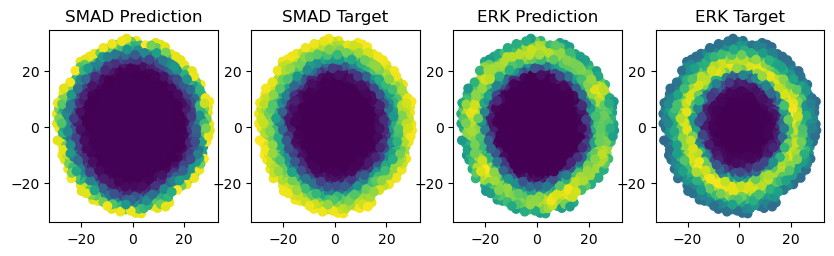

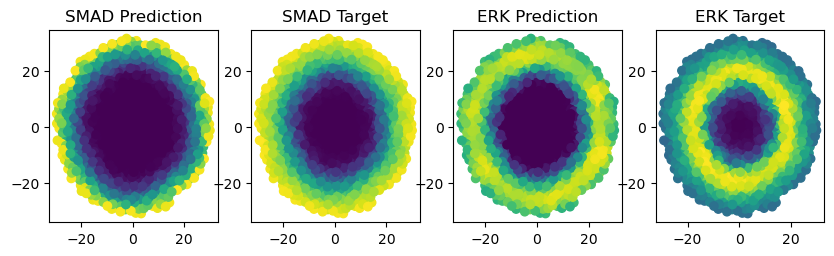

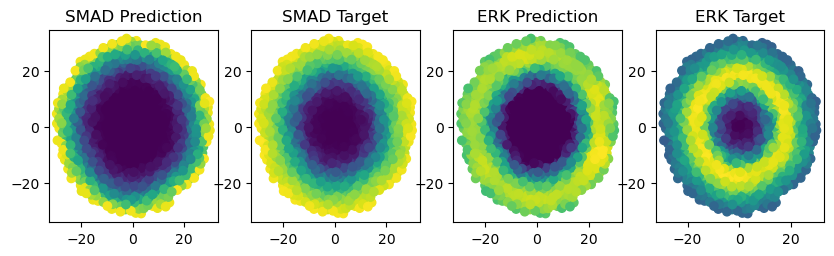

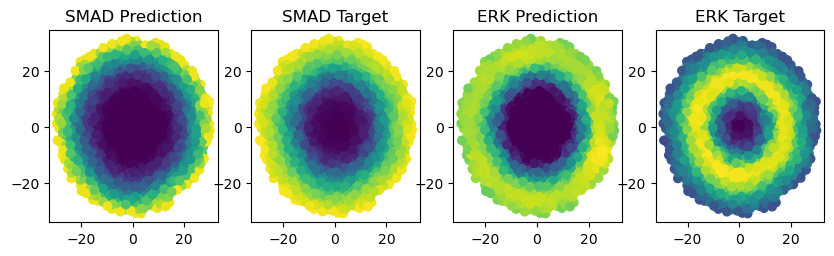

np.float64(14.800670480040187)

In [10]:
# load model
stepsize = 5
model = CustomGNN(3, [6], 2, aggregation="mean", biases = False)
model.load_state_dict(torch.load("model200.pth"))

get_quality(model, data, positions, stepsize, show = 4)


In [21]:
import sympy as sp

# set up the variables
S = sp.symbols('S', positive=True, real=True)
E = sp.symbols('E', positive=True, real=True)
B = sp.symbols('B', positive=True, real=True)
nb_S = sp.symbols('S_nb', positive=True, real=True)
nb_E = sp.symbols('E_nb', positive=True, real=True)
nb_B = sp.symbols('B_nb', positive=True, real=True)

inp_vec = sp.Matrix([ S, E, B, nb_S, nb_E, nb_B,])
# inp_vec = sp.Matrix([ S,B, nb_S,nb_B,])
inp_vec = sp.Matrix([S, B, nb_S, nb_B,])

# calculate the first layer
W0 = sp.Matrix(weights[0] * ~prune_masks[0])

X = W0*inp_vec
activation = sp.Function('sigma')

# activation = lambda x: x if x > 0 else 0
# activation = lambda x: x


XXX = []
for x in X:
    terms = sp.Add.make_args(x)
    if terms is None:
        XXX.append(x)
        continue

    if all(np.array(terms)>0):
        XXX.append(x)
        continue
    
    if all(np.array(terms)<0):
        XXX.append(0)
        continue

    XXX.append(activation(x))

# X = sp.Matrix([activation(x) for x in X])
X = sp.Matrix(XXX)

# squared

# sigmoid
# activation = lambda x: 1/(1 + sp.exp(-x))

# softplus
# activation = lambda x: sp.log(1 + sp.exp(x))


for i in range(1, len(weights)):
    W = sp.Matrix(weights[i] * ~prune_masks[i])
    X = W*X

    if i != len(weights)-1:
        X = sp.Matrix([activation(x) for x in X])

# define the activation function



# calculate the second layer

# simplify the expression


X

Matrix([[0.0349407*B + 0.63202*S + 0.357722*S_nb]])

In [191]:
# define differences 
S_diff = sp.symbols('S_diff', positive=True, real=True)
E_diff = sp.symbols('E_diff', positive=True, real=True)
B_diff = sp.symbols('B_diff', positive=True, real=True)

X_subbed = X.subs({S: nb_S + S_diff, E: nb_E + E_diff, B: nb_B + B_diff})

simp = sp.simplify(X,)
simp[0]


0.2185*E_nb - 0.011138*S + 0.262114*S_nb + 0.064207*sigma(-1.46919*B_nb - 0.338297*E + 1.8317*E_nb) + 0.113426*sigma(2.32898*B_nb - 1.49906*E_nb - 1.26453*S_nb) + 0.0281599*sigma(-0.439438*B - 0.642633*B_nb + 1.5287*E_nb + 1.13931*S_nb)